In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode to 2
%autoreload 2

import base64
from getpass import getpass
from PIL import Image

from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, SVG
import json
import re
import os
from dotenv import load_dotenv
import anthropic
import torchvision.transforms as transforms
import xml.etree.ElementTree as ET
import time
import ast
import cairosvg

import sys
sys.path.append("..") # Adds higher directory to python modules path.
from prompts import sketch_first_prompt, system_prompt, gt_example
import utils

In [2]:
load_dotenv()
claude_key = os.getenv("ANTHROPIC_API_KEY")
client = anthropic.Anthropic(api_key=claude_key)
model = "claude-3-5-sonnet-20240620"
gen_mode = "generation"
max_tokens=3000

res=50
init_canvas, cells_to_pixels_map = utils.create_grid_image(res=res, cell_size=12, header_size=12)

# Utils

In [10]:
def load_sketch_data(path_to_data, object_to_edit, cache=False):
    path_to_sketch_im = f"{path_to_data}/{object_to_edit}/{object_to_edit}_canvas.png"
    path_to_json = f"{path_to_data}/{object_to_edit}/experiment_log.json"

    with open(path_to_json, 'r') as file:
        experiment_log = json.load(file)
        if cache:
            system_prompt = experiment_log[0]["content"][0]["text"]
        else:
            system_prompt = experiment_log[0]["content"]
        assitant_prompt = experiment_log[-1]['content'][0]['text']
        msg_history = experiment_log[1:]

    sketch_rendered = Image.open(path_to_sketch_im)
    return sketch_rendered, system_prompt, msg_history, assitant_prompt

def call_llm(system_message, other_msg, cache, additional_args):
    if cache:
        init_response = client.beta.prompt_caching.messages.create(
                model=model,
                max_tokens=max_tokens,
                system=system_message,
                messages=other_msg,
                **additional_args
            )
    else:
        init_response = client.messages.create(
                model=model,
                max_tokens=max_tokens,
                system=system_message,
                messages=other_msg,
                **additional_args
            )
    return init_response

def define_input_to_llm(msg_history, init_canvas_str, msg, cache):
    # other_msg should contain all messgae without the system prompt
    other_msg = msg_history

    content = []
    # Claude best practice is image-then-text
    if init_canvas_str is not None:
        content.append({"type": "image", "source": {"type": "base64", "media_type": "image/jpeg", "data": init_canvas_str}})

    content.append({"type": "text", "text": msg})
    if cache:
        content[-1]["cache_control"] = {"type": "ephemeral"}

    other_msg = other_msg + [{"role": "user", "content": content}]
    return other_msg

def get_response_from_llm(
        msg,
        system_message,
        msg_history=[],
        init_canvas_str=None,
        prefill_msg=None,
        seed_mode="stochastic",
        stop_sequences=None,
        gen_mode="generation",
        cache=True,
        path2save=None
    ):
        additional_args = {}
        if seed_mode == "deterministic":
            additional_args["temperature"] = 0.0
            additional_args["top_k"] = 1

        if cache:
            system_message = [{
                "type": "text",
                "text": system_message,
                "cache_control": {"type": "ephemeral"}
            }]

        # other_msg should contain all messgae without the system prompt
        other_msg = define_input_to_llm(msg_history, init_canvas_str, msg, cache)

        if gen_mode == "completion":
            if prefill_msg:
                other_msg = other_msg + [{"role": "assistant", "content": f"{prefill_msg}"}]

            # in case of stroke by stroke generation
        if stop_sequences:
            additional_args["stop_sequences"]= [stop_sequences]
        else:
            additional_args["stop_sequences"]= ["</answer>"]

        # Note that we deterministic settings for reproducibility (temperature=0.0 and top_k=1).
        # To run in stochastic mode just comment these parameters.
        response = call_llm(system_message, other_msg, cache, additional_args)

        content = response.content[0].text

        if gen_mode == "completion":
            other_msg = other_msg[:-1] # remove initial assistant prompt
            content = f"{prefill_msg}{content}"

        # saves to json
        if path2save is not None:
            system_message_json = [{"role": "system", "content": system_message}]
            new_msg_history = other_msg + [
                {
                    "role": "assistant",
                    "content": [
                        {
                            "type": "text",
                            "text": content,
                        }
                    ],
                }
            ]
            with open(f"{path2save}/experiment_log.json", 'w') as json_file:
                json.dump(system_message_json + new_msg_history, json_file, indent=4)
            print(f"Data has been saved to [{path2save}/experiment_log.json]")

        return content, new_msg_history


def save_sketch(model_strokes_svg, output_path, add_object, init_canvas):
    with open(f"{output_path}/{add_object}.svg", "w") as svg_file:
        svg_file.write(model_strokes_svg)

    # save the result also without the canvas background
    cairosvg.svg2png(url=f"{output_path}/{add_object}.svg", write_to=f"{output_path}/{add_object}.png", background_color="white")

    if init_canvas is not None:
        # save the result as png on the canvas background
        output_png_path = f"{output_path}/{add_object}_canvas.png"
        cairosvg.svg2png(url=f"{output_path}/{add_object}.svg", write_to=output_png_path)
        foreground = Image.open(output_png_path)
        init_canvas_copy = init_canvas.copy()
        init_canvas_copy.paste(Image.open(output_png_path), (0, 0), foreground)
        init_canvas_copy.save(output_png_path)
        return init_canvas_copy

# Edit

### Edit mode - Add
Adds content to existing sketch (note the prompt are adjusted to the type of edit)

In [12]:
def edit_sketch_in_chat_add(path_to_data, object_to_edit, add_objects, reflection_prompt, cache, seed_mode="deterministic"):
    output_path = f"{path_to_data}/{object_to_edit}/editing_add"
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Load sketch data
    sketch_rendered, system_prompt, msg_history, assitant_prompt = load_sketch_data(path_to_data, object_to_edit, cache)
    with open(f"{output_path}/experiment_log.json", 'w') as json_file:
        system_message_json = [{"role": "system", "content": system_prompt}]
        json.dump(system_message_json + msg_history, json_file, indent=4)

    # Save given strokes
    prev_strokes_list_str, prev_t_values_str = utils.parse_xml_string(assitant_prompt, res=res)
    accum_strokes_list, accum_t_values = ast.literal_eval(prev_strokes_list_str), ast.literal_eval(prev_t_values_str)
    cur_sketch_str = utils.image_to_str(sketch_rendered)

    # Add objects in a loop
    for add_object in add_objects:
        user_edit_prompt = reflection_prompt.format(add_object=add_object, object_to_edit=object_to_edit)

        all_llm_output, new_msg_history = get_response_from_llm(
                    msg=user_edit_prompt,
                    system_message=system_prompt.format(res=res),
                    msg_history=msg_history,
                    init_canvas_str=cur_sketch_str,
                    seed_mode=seed_mode,
                    gen_mode=gen_mode,
                    cache=cache,
                    path2save=output_path
                )

        strokes_list_str, t_values_str = utils.parse_xml_string(all_llm_output, res=res)
        strokes_list, t_values = ast.literal_eval(strokes_list_str), ast.literal_eval(t_values_str)
        # this is the part where we add the new strokes to existing ones:
        accum_strokes_list.extend(strokes_list)
        accum_t_values.extend(t_values)
        all_control_points = utils.get_control_points(accum_strokes_list, accum_t_values, cells_to_pixels_map)
        model_strokes_svg = utils.format_svg(all_control_points, dim=(600,600), stroke_width=7.0)
        sketch_rendered = save_sketch(model_strokes_svg, output_path, add_object, init_canvas)

        plt.imshow(sketch_rendered)
        plt.show()

        cur_sketch_str = utils.image_to_str(sketch_rendered)
        msg_history = msg_history + [
                {
                    "role": "assistant",
                    "content": [
                        {
                            "type": "text",
                            "text": all_llm_output,
                        }
                    ],
                }
            ]

Data has been saved to [/Users/dianne/Desktop/MIT/Sketch Agent/SketchAgent/results/test//tiger/editing_add/experiment_log.json]


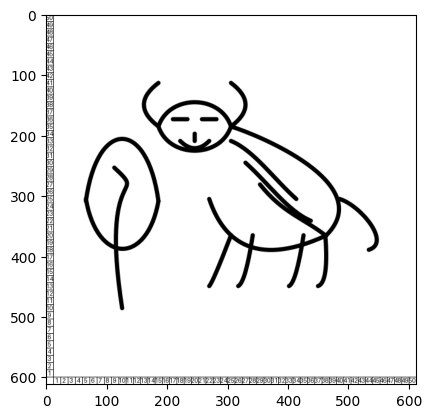

Data has been saved to [/Users/dianne/Desktop/MIT/Sketch Agent/SketchAgent/results/test//tiger/editing_add/experiment_log.json]


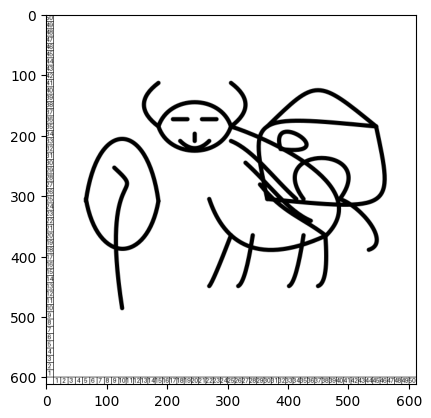

Data has been saved to [/Users/dianne/Desktop/MIT/Sketch Agent/SketchAgent/results/test//tiger/editing_add/experiment_log.json]


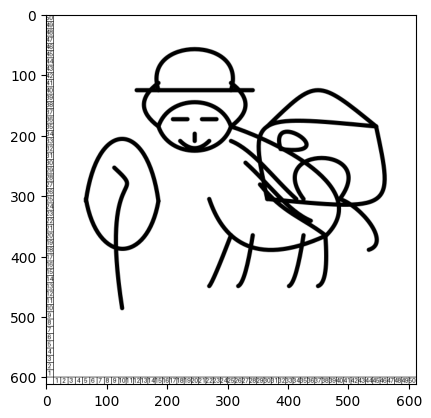

In [13]:
# This is the editing code.
# Editing in this case is performed on top of an existing sketch. This code assumes the results are under "path_to_data/object_to_edit",
# and loads the sketch from the json file and parse it etc.
# load image and text input
path_to_data = "/Users/dianne/Desktop/MIT/Sketch Agent/SketchAgent/results/test/" # change to your path
object_to_edit = "tiger"
cache=False # should fit the mode used when running the example above (usually set to False)

# The following is designed for the purposes I needed, you can change it.
# Basically the concepts in the list are added in a loop.
# Please look at the "reflection_prompt" carefully, understand the instructions etc.
add_objects = ["a tree to the left", "a house to the right", "a hat on the tiger's head"]
reflection_prompt = """Add {add_object}. Describe the location of the added concept first in <thinking> tags. Only provide the added strokes. Respond in the same format as before. Be concise."""

edit_sketch_in_chat_add(path_to_data, object_to_edit, add_objects, reflection_prompt, cache, seed_mode="stochastic")